In [ ]:
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
import albumentations as A
from tqdm.auto import tqdm
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch
import io


from src.model import BoneNet
from src.utils import get_all_images
from src.inference import BoneDatasetTest, ensemble_predict

In [ ]:
TEST_DIR = "./test-data"
img_paths = get_all_images(TEST_DIR)

In [ ]:
test_transforms = A.Compose([A.Normalize(), ToTensorV2()])

In [ ]:
dst = BoneDatasetTest(img_paths, transforms=test_transforms)
test_dataloader = DataLoader(
    dst, batch_size=32, shuffle=False, num_workers=4, pin_memory=True
)

In [ ]:
NUM_FOLDS = 4
models = [
    BoneNet.load_from_checkpoint(f"effnet_fold{fold}.ckpt") for fold in range(NUM_FOLDS)
]

for i, images in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    avg_preds = ensemble_predict(images, models)

avg_preds

  0%|          | 0/1 [00:00<?, ?it/s]

[[158.23703 203.98897 165.8212  162.37105 174.21895 183.4889  172.97977
  192.67184 171.3216  194.93742 160.14287 185.07901 165.2255 ]]
[[160.77576 201.14357 166.67763 162.30847 178.0085  183.0023  176.21144
  200.84857 168.99702 193.17786 160.839   183.30203 164.95105]]
[[158.7543  203.20995 172.81145 163.75716 176.56868 182.47816 173.73174
  195.27133 170.66188 193.72021 163.06784 182.34521 168.31316]]
[[158.19633 202.67796 171.7063  161.43971 177.98882 184.71057 171.8016
  200.06189 170.17624 194.9496  159.573   190.30551 165.38591]]


array([[159., 203., 169., 162., 177., 183., 174., 197., 170., 194., 161.,
        185., 166.]], dtype=float32)

In [39]:
test_targets = pd.read_csv("test.csv").rename({"Growth Plate Index": "y"}, axis=1)
test_targets

,STUDY ID,Bone ID,Image Name,y
0,1,2,feaec917f3,199
1,0,1,a82c3c2965,165
2,2,3,8c9b119aa2,185
3,2,4,5dd1c0c131,180
4,1,4,f27da128ab,175
5,2,1,6eb0a13a01,169
6,2,1,eda8dfa0ed,173
7,0,1,faf967f332,180
8,2,3,d7cd090ca8,190
9,2,2,64d33d4c9c,182


In [ ]:
import pandas as pd

df = pd.DataFrame(
    {
        "Image Name": [Path(path).stem for path in img_paths],
        "Growth Plate Index": (avg_preds.squeeze()).astype(int),
    }
)
df.sort_values(by="Image Name").to_csv("predictions.csv", index=False)
df

,Image Name,Growth Plate Index
0,22e989cc9b,159
1,7081e041aa,203
2,eda8dfa0ed,169
3,6eb0a13a01,162
4,5dd1c0c131,177
5,8c9b119aa2,183
6,f27da128ab,174
7,feaec917f3,197
8,faf967f332,170
9,d7cd090ca8,194


In [43]:
df = df.merge(test_targets, on="Image Name")

In [44]:
df

,Image Name,Growth Plate Index,STUDY ID,Bone ID,y
0,22e989cc9b,159,0,3,160
1,7081e041aa,203,2,2,199
2,eda8dfa0ed,169,2,1,173
3,6eb0a13a01,162,2,1,169
4,5dd1c0c131,177,2,4,180
5,8c9b119aa2,183,2,3,185
6,f27da128ab,174,1,4,175
7,feaec917f3,197,1,2,199
8,faf967f332,170,0,1,180
9,d7cd090ca8,194,2,3,190


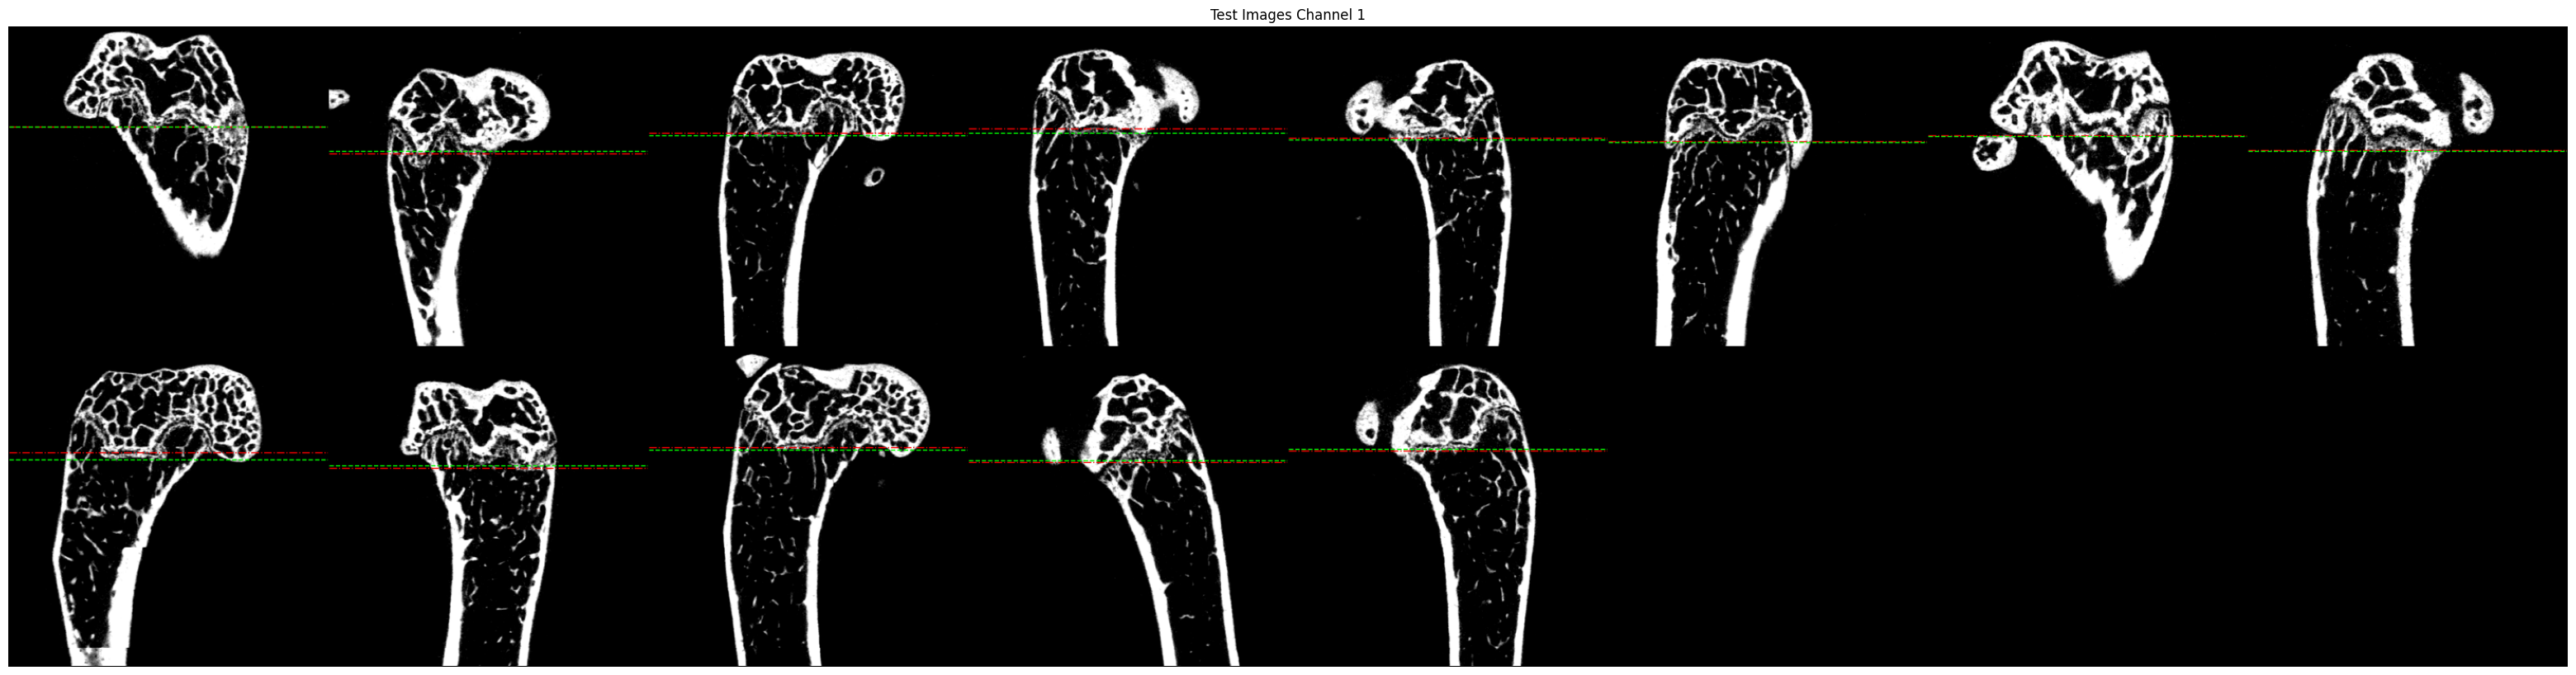

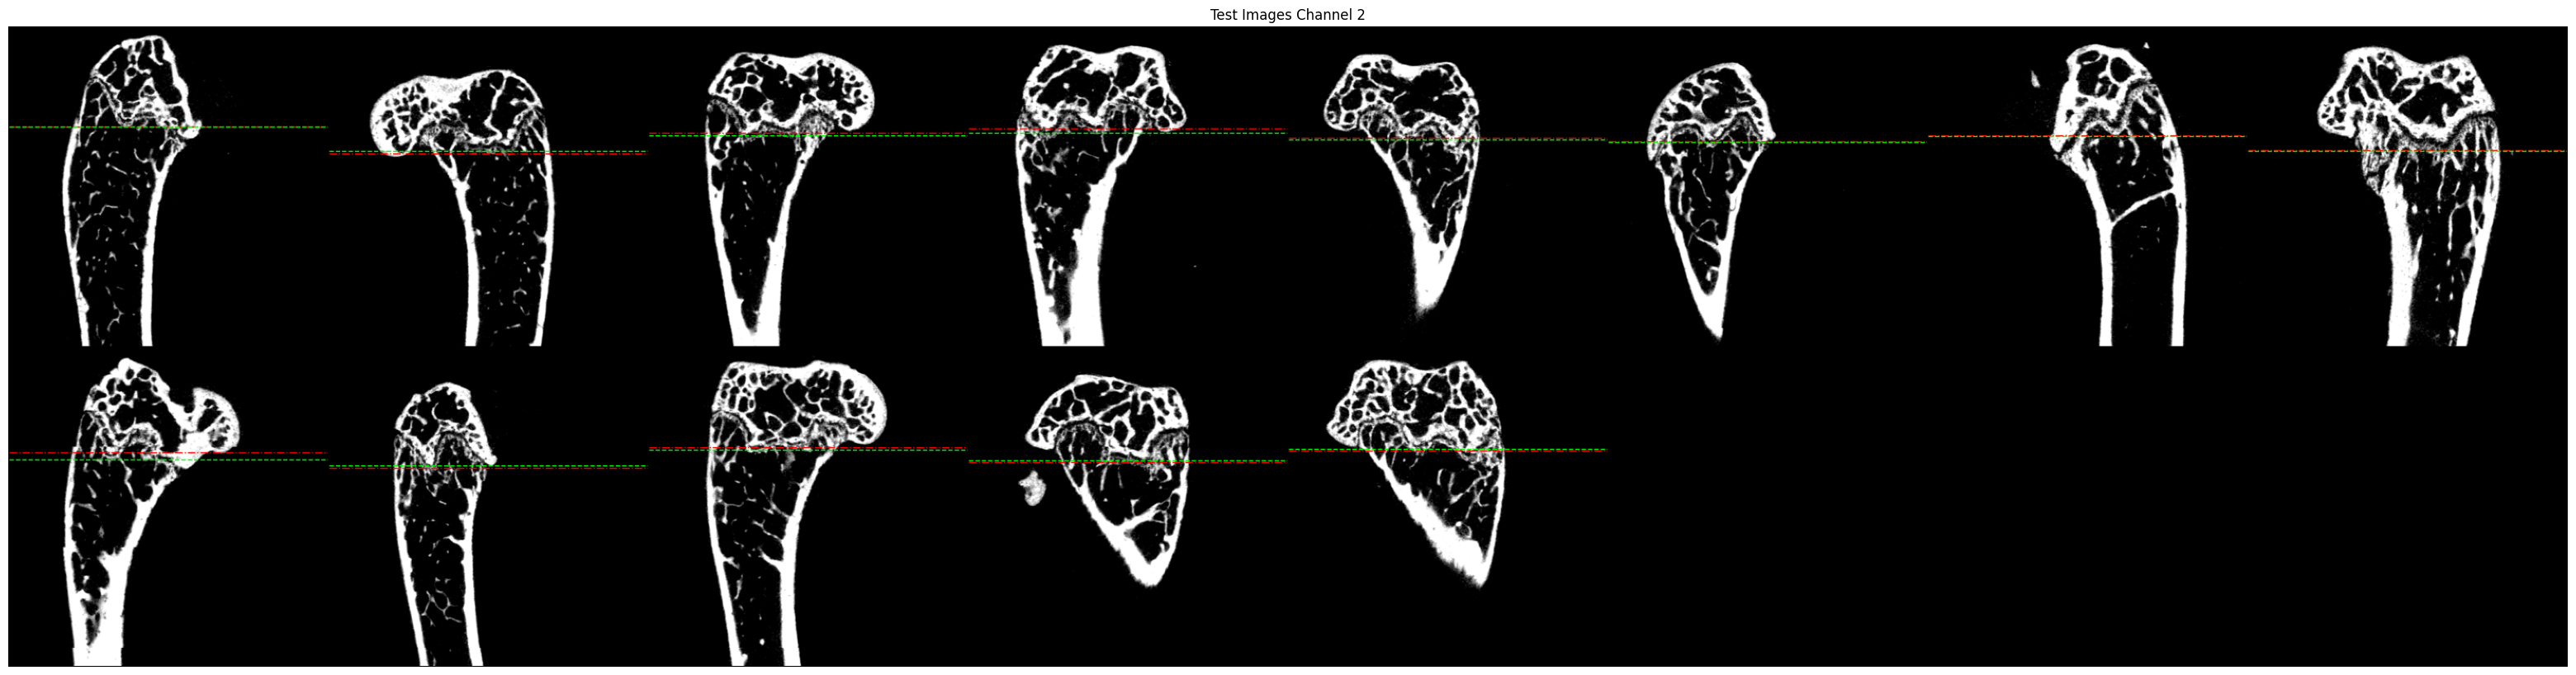

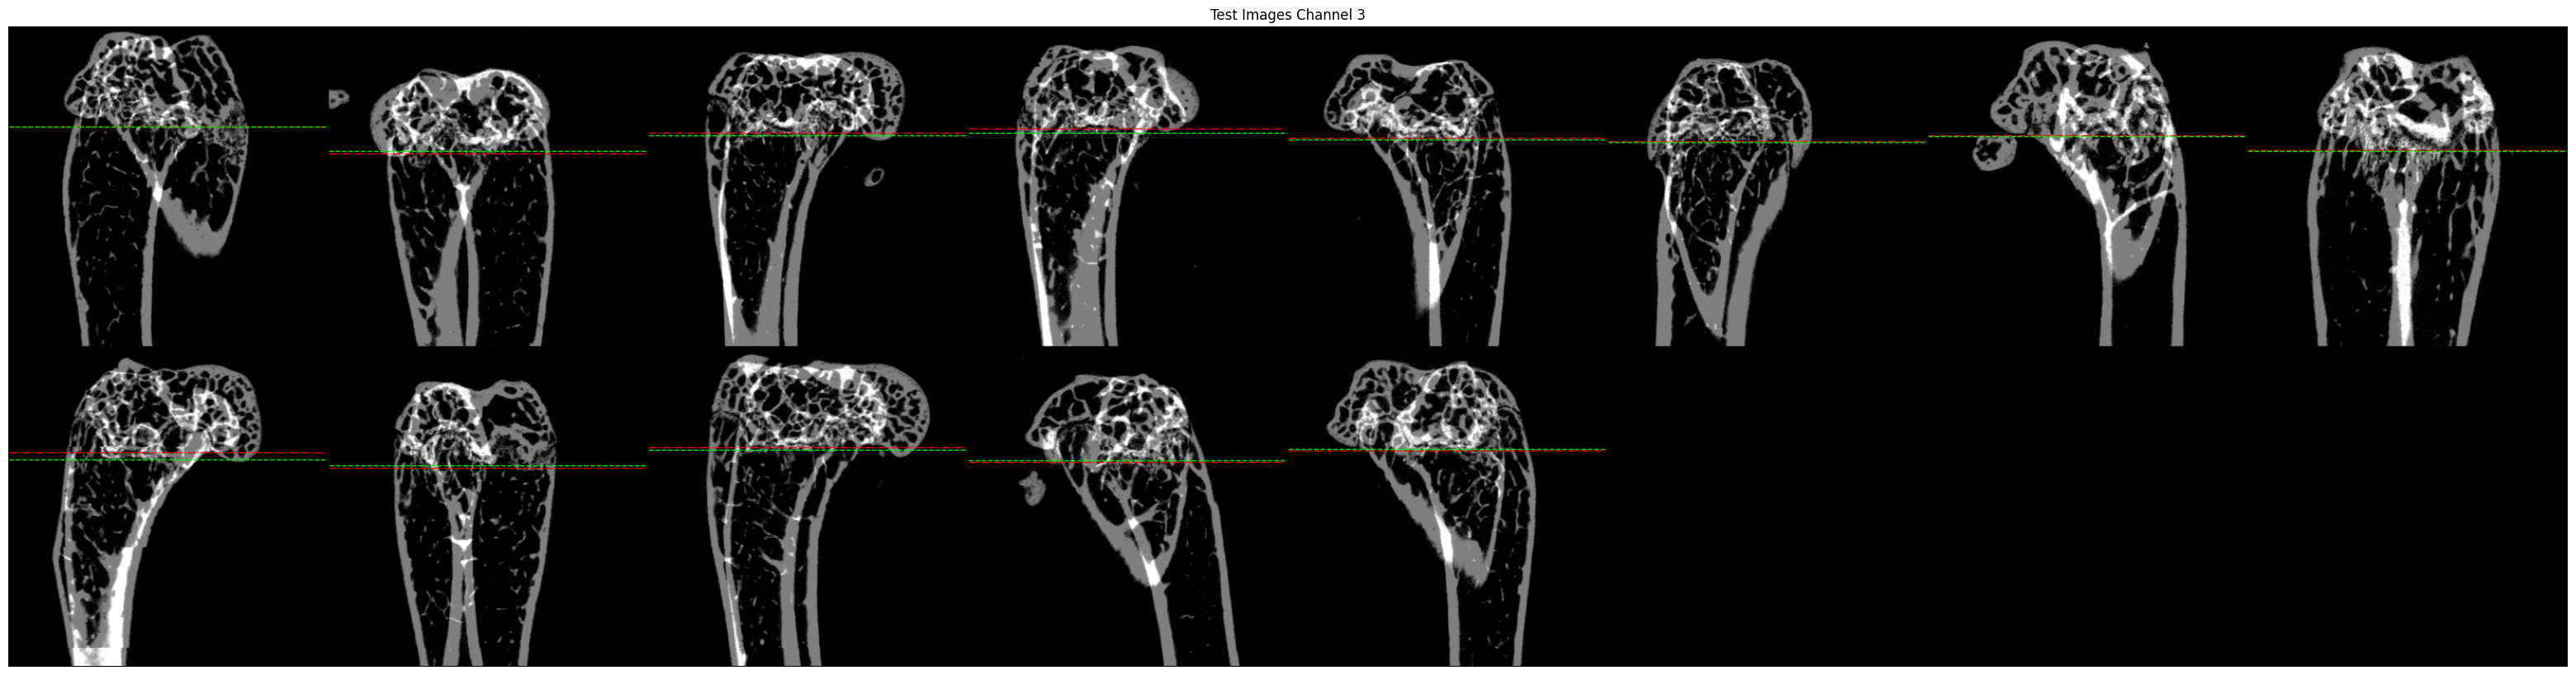

In [ ]:
gp_idxs = avg_preds.squeeze()

for images in test_dataloader:
    break

for c in range(3):
    processed_images = []
    for idx, image in enumerate(images):
        img = image[c].numpy()

        fig, ax = plt.subplots()
        ax.imshow(img, cmap="gray")
        ax.axhline(y=gp_idxs[idx], color="#FF0000", linestyle="-.", linewidth=1)
        ax.axhline(y=df.y.iloc[idx], color="#00FF00", linestyle="--", linewidth=1)
        ax.axis("off")

        buf = io.BytesIO()
        plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
        buf.seek(0)
        img_with_line = plt.imread(buf)
        buf.close()

        img_with_line = (img_with_line[:, :, :3] * 255).astype(np.uint8)
        processed_images.append(torch.from_numpy(img_with_line).permute(2, 0, 1))
        plt.close(fig)

    processed_images = torch.stack(processed_images).float() / 255.0
    grid = torchvision.utils.make_grid(processed_images, padding=1, normalize=False)

    plt.figure(figsize=(40, 20))
    plt.axis("off")
    plt.title(f"Test Images Channel {c+1}")
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()